Following code downloads the dataset `horse-or-human.zip` in `files` folder

In [2]:
import os
import gdown

path = './files/'
if not os.path.exists(path):
    os.makedirs(path)

url = 'https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5'
output = './files/horse-or-human.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: D:\OneDrive - Montana State University\Learning\Coursera\Intro_to_TensorFlow_for_AI_ML_DL\files\horse-or-human.zip
100%|███████████████████████████████████████████████████████████████████████████████| 150M/150M [00:13<00:00, 10.8MB/s]


'./files/horse-or-human.zip'

Unzip the dataset

In [3]:
import zipfile

zip_ref  = zipfile.ZipFile(output, 'r')
zip_ref.extractall('./files/horse-or-human')
zip_ref.close()

Define the training directorues and take a look at the filenames

In [4]:
train_horse_dir = os.path.join('./files/horse-or-human/horses/')
train_human_dir = os.path.join('./files/horse-or-human/humans/')

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


Check the total number of images

In [5]:
print('Total training horse images:', len(train_horse_names))
print('Total training human images:', len(train_human_names))

Total training horse images: 500
Total training human images: 527


Let's take a look at a few pictures randomly

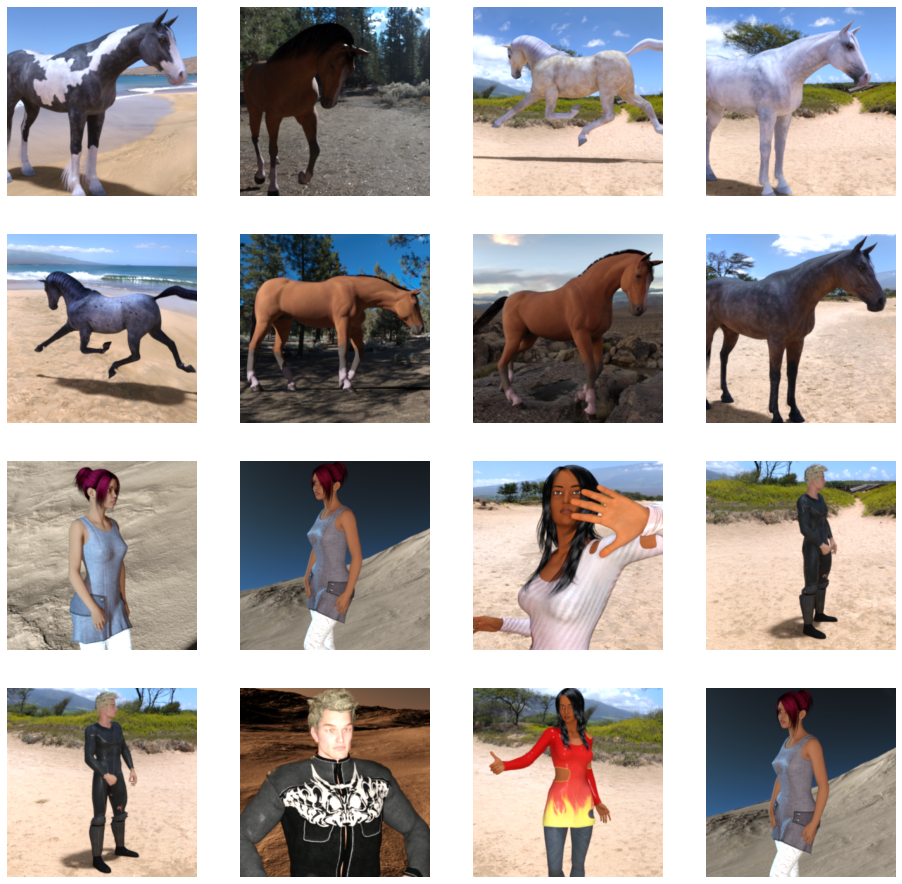

In [6]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 4x4 subplot image
nrows = 4
ncols = 4

# randomly select 8 images
horse_idx = random.sample(range(len(train_horse_names)), 8)
human_idx = random.sample(range(len(train_human_names)), 8)

# set up matplotlib figure and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(nrows * 4, ncols * 4)

next_horse_pic = [os.path.join(train_horse_dir, train_horse_names[idx])
                 for idx in horse_idx]
next_human_pic = [os.path.join(train_human_dir, train_human_names[idx])
                 for idx in human_idx]

for i, img_path in enumerate(next_horse_pic + next_human_pic):
    # subplot index starts at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

Build the model

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a [sigmoid activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [7]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid.

We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
             optimizer = RMSprop(learning_rate = 0.001),
             metrics = ['accuracy'])

Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

# flow training images in batches of 128 using the train_datagen generator
train_generator = train_datagen.flow_from_directory(
    './files/horse-or-human/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary' # Since we use binary_crossentropy loss, we need binary labels
)

Found 1027 images belonging to 2 classes.


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch = 8, # (1027/128)
    epochs = 15,
    verbose = 1
)

Epoch 1/15
8/8 [==============================] - 22s 3s/step - loss: 0.9964 - accuracy: 0.5028
Epoch 2/15
8/8 [==============================] - 21s 3s/step - loss: 0.7176 - accuracy: 0.5973
Epoch 3/15
8/8 [==============================] - 21s 3s/step - loss: 0.6074 - accuracy: 0.6930
Epoch 4/15
8/8 [==============================] - 21s 2s/step - loss: 0.8053 - accuracy: 0.6418
Epoch 5/15
8/8 [==============================] - 21s 3s/step - loss: 0.5999 - accuracy: 0.6663
Epoch 6/15
8/8 [==============================] - 22s 3s/step - loss: 1.4216 - accuracy: 0.8065
Epoch 7/15
8/8 [==============================] - 22s 3s/step - loss: 0.2806 - accuracy: 0.8788
Epoch 8/15
8/8 [==============================] - 22s 3s/step - loss: 0.5987 - accuracy: 0.8142
Epoch 9/15
8/8 [==============================] - 22s 3s/step - loss: 0.1645 - accuracy: 0.9555
Epoch 10/15
8/8 [==============================] - 25s 3s/step - loss: 0.0678 - accuracy: 0.9814
Epoch 11/15
8/8 [======================

Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [11]:
import tkinter as tk
import tkinter.filedialog as fd

root = tk.Tk()
filez = fd.askopenfilenames(parent=root, title='Choose a file')
print(filez)

('D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-g0a970d487_640.jpg', 'D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-g3e542f304_640.jpg', 'D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-gb3b058e63_640.jpg', 'D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/photographer-g91148e61c_640.jpg', 'D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/suitcase-g9d350dfd2_640.jpg', 'D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/woman-g0da493694_640.jpg')


In [12]:
import numpy as np
from keras.preprocessing import image

for i, path in enumerate(filez):
    img = image.load_img(path, target_size = (300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size = 10)
    print(classes[0])
    if classes[0] > 0.5:
        print(path + 'is a human')
    else:
        print(path + 'is a horse')

[1.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-g0a970d487_640.jpgis a human
[1.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-g3e542f304_640.jpgis a human
[0.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/horse-gb3b058e63_640.jpgis a horse
[1.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/photographer-g91148e61c_640.jpgis a human
[1.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/suitcase-g9d350dfd2_640.jpgis a human
[1.]
D:/OneDrive - Montana State University/Learning/Coursera/Intro_to_TensorFlow_for_AI_ML_DL/files/pixabay_images/woman-g0da493694_640.jpgis a human


Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

C:\Users\SID\AppData\Local\Temp/ipykernel_24256/1517701745.py:42: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


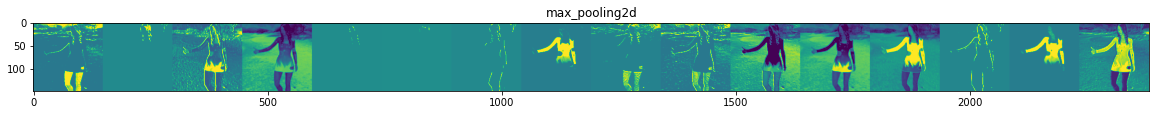

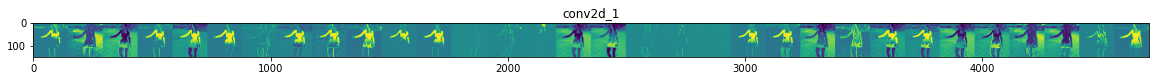

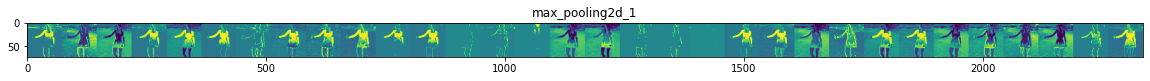

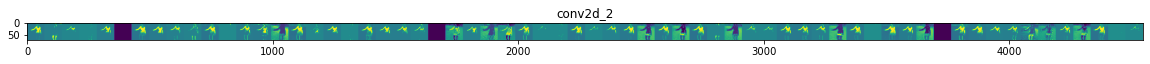

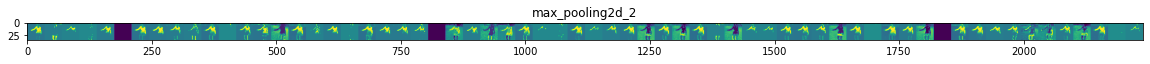

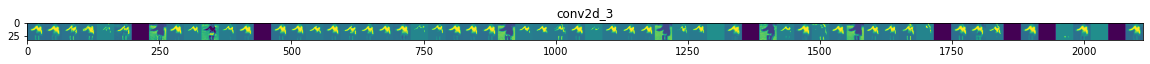

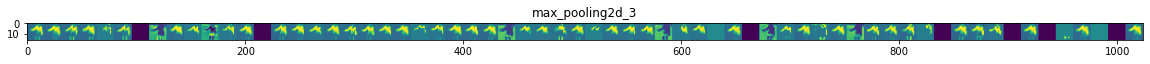

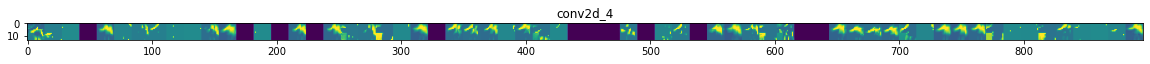

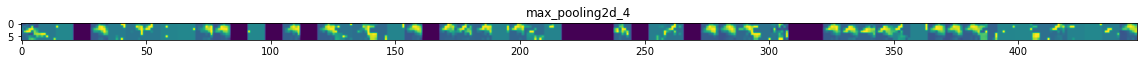

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# let's define a new model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)

# let's prepare a random input image from the training set
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size = (300, 300)) # this is a PIL (python image library) image
x = img_to_array(img) # numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape) # numpy array with shape (1, 300, 300, 3)

# rescale by 1/255
x /= 255

# let's run the image through our network,  thus obtaining all
# intermediate representations for this image
successive_feature_maps = visualization_model.predict(x)

# these are the name of the layers
layer_names = [layer.name for layer in model.layers[1:]]

# display the representation
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # do this for conv/maxpool layers, not fully-connected layers
        n_features = feature_map.shape[-1] # number of features in feature map
        # feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # tile images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # post-process the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # display the grid
        scale = 20./ n_features
        plt.figure(figsize = (scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')